# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> AC209a Twitter Project - Group 15

## Experiments with Twitter API

**Harvard University**<br/>
**Fall 2018**<br/>
**Project Authors**: Claire Stolz, Matthew Stewart, Yiming Qin & Tianning Zhao <br>
**Assigned Teaching Fellow**: Brandon Lee

<hr style="height:2pt">

In [1]:
%%capture
# RUN THIS CELL FOR FORMAT
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### Important packages

1. `Tweepy` - Twitter API - http://docs.tweepy.org/en/v3.5.0/api.html#tweepy-api-twitter-api-wrapper

2. `nltk` - Natural language processing library - http://www.nltk.org/howto/twitter.html

3. `twython` - Python wrapper for the Twitter API

4. `jsonpickle` - converts Python objects into JSON

5. `scikit-learn` - Python machine learning library

https://github.com/Jefferson-Henrique/GetOldTweets-python

In [33]:
!pip install --upgrade jsonpickle tweepy

import sys
import jsonpickle
import os
import numpy as np
import pandas as pd
import tweepy
import nltk
import pandas as pd
import json
import sklearn
import datetime
from datetime import datetime
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn import svm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from pandas.io.json import json_normalize
import warnings
warnings.filterwarnings('ignore')

Requirement already up-to-date: jsonpickle in /Users/yiming/anaconda3/lib/python3.6/site-packages (1.0)
Requirement already up-to-date: tweepy in /Users/yiming/anaconda3/lib/python3.6/site-packages (3.7.0)


# Baseline Model

In this section we will run a baseline model on a dataset with a limited number of features.

# Part I: Baseline Model  with two features


## data processing

In [4]:
total_df = pd.read_csv(r"total_df.csv")
train_data, test_data = train_test_split(total_df, test_size = 0.3)
X_train_log = pd.DataFrame()
X_train = train_data[['followers_count','friends_count']]; 
X_train_log['followers_count'] = np.log10(train_data['followers_count'])
X_train_log['friends_count'] = np.log10(train_data['friends_count'])
Y_train = train_data[['bot']]

X_test_log = pd.DataFrame()
X_test_log['followers_count'] = np.log10(test_data['followers_count'])
X_test_log['friends_count'] = np.log10(test_data['friends_count'])
X_test = test_data[['followers_count','friends_count']]
Y_test = test_data[['bot']]
X_train_log = X_train_log.replace(-np.inf, 0)
X_test_log = X_test_log.replace(-np.inf, 0)

In [42]:
def overlay_decision_boundary(ax, model, colors=None, nx=200, ny=200, desaturate=.5):
    """
    A function that visualizes the decision boundaries of a classifier.
    
    ax: Matplotlib Axes to plot on
    model: Classifier (has a `.predict` method)
    X: feature vectors
    y: ground-truth classes
    colors: list of colors to use. Use color colors[i] for class i.
    nx, ny: number of mesh points to evaluated the classifier on
    desaturate: how much to desaturate each of the colors (for better contrast with the sample points)
    """
    # Create mesh
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, nx),
        np.linspace(ymin, ymax, ny))
    X = np.c_[xx.flatten(), yy.flatten()]

    # Predict on mesh of points
    if hasattr(model, 'predict'):
        model = model.predict
    y = model(X)
    y = y.reshape((nx, ny))

    # Generate colormap.
    if colors is None:
        colors = sns.utils.get_color_cycle()
        y -= y.min() # If first class is not 0, shift.
    assert np.max(y) <= len(colors)
    colors = [sns.utils.desaturate(color, desaturate) for color in colors]
    cmap = matplotlib.colors.ListedColormap(colors)

    # Plot decision surface
    ax.pcolormesh(xx, yy, y, zorder=-2, cmap=cmap, norm=matplotlib.colors.NoNorm(), vmin=0, vmax=y.max() + 1)
    xx = xx.reshape(nx, ny)
    yy = yy.reshape(nx, ny)
#     ax.contourf(xx, yy, y, cmap=cmap, vmin=0, vmax=3)
    ax.contour(xx, yy, y, colors="black", linewidths=1, zorder=-1)

In [43]:
def makeAx(df_x=total_df):    
    fig, ax = plt.subplots(figsize=(16,5))
    groups = df_x.groupby('bot')
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    names = {'0':'Legitimate User', '1':'Bot'}
    for name, group in groups:
        ax.plot(group['followers_count'], group['friends_count'], marker='o', alpha=0.8, linestyle=' ', ms=7, label=names[str(name)])
    ax.legend()
    ax.set_xlabel('Followers Count ($log_{10}$)', size=16)
    ax.set_ylabel('Friends Count ($log_{10}$)', size=16)
    ax.legend(loc='best',fontsize='x-large')
    ax.set_title('Scatterplot of followers and friends count for each class of user', size=18);
    return (fig, ax)

In [44]:
def makeAx_log(df_x=total_df):    
    fig, ax = plt.subplots(figsize=(10,5))
    groups = df_x.groupby('bot')
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    names = {'0':'Legitimate User', '1':'Bot'}
    for name, group in groups:
        ax.plot(np.log10(group['followers_count']), np.log10(group['friends_count']), marker='o', alpha=0.8, linestyle=' ', ms=7, label=names[str(name)])
    ax.legend()
    ax.set_xlabel('Followers Count ($log_{10}$)', size=16)
    ax.set_ylabel('Friends Count ($log_{10}$)', size=16)
    ax.legend(loc='best',fontsize='x-large')
    ax.set_title('Scatterplot of followers and friends count for each class of user', size=18);
    return (fig, ax)

## Logistic Regression

In [20]:
logreg = LogisticRegression(C=100000,fit_intercept=True).fit(X_train,Y_train)
acc = accuracy_score(Y_train,logreg.predict(X_train), normalize=True)

# Logistic regression w/ quadratic + interaction terms + regularization
polynomial_logreg_estimator = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=True),
    LogisticRegressionCV(multi_class="ovr", penalty='l2', cv=5, max_iter=10000))
linearLogCVpoly = polynomial_logreg_estimator.fit(X_train, Y_train);

## LDA and QDA Model

In [19]:
lda = LinearDiscriminantAnalysis(store_covariance=True)
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
lda.fit(X_train_log, Y_train)
qda.fit(X_train_log, Y_train)
lda.predict(X_test_log)
qda.predict(X_test_log);

## random forest

In [23]:
ntrees = 50
rf = RandomForestClassifier(n_estimators=ntrees , max_depth=15, max_features='auto')
rf.fit(X_train_log, Y_train)
train_score_rf=rf.score(X_train_log, Y_train)
test_score_rf=rf.score(X_test_log, Y_test)

## Adaboost

In [24]:
adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=800, learning_rate=0.01)
adaboost.fit(X_train_log, Y_train);

## XGboost

In [29]:
gbm = xgb.XGBClassifier(max_depth=5, n_estimators=300, learning_rate=0.01).fit(X_train_log, Y_train)
y_pred = gbm.predict(X_test_log)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(Y_test, predictions)

## KNN

In [54]:
scores_mean=[]
scores_std=[]

k_number=np.arange(1,50)

for k in range(1,50):
    knn = KNeighborsClassifier(n_neighbors = k)
    score_mean= cross_val_score(knn,X_train,Y_train,cv=5).mean()
    score_std=cross_val_score(knn,X_train,Y_train,cv=5).std()
    scores_mean.append(score_mean)

max_score_k=max(scores_mean)
best_k=scores_mean.index(max(scores_mean))+1
print('Best K=',best_k, 'with a max CV score of',max_score_k)

knn_best_k = KNeighborsClassifier(n_neighbors = best_k)
knn_best_k.fit(X_train_log,Y_train);

pred_best_k = knn_best_k.predict(X_test_log)

Best K= 11 with a max CV score of 0.8980620155038761


## Model comparison

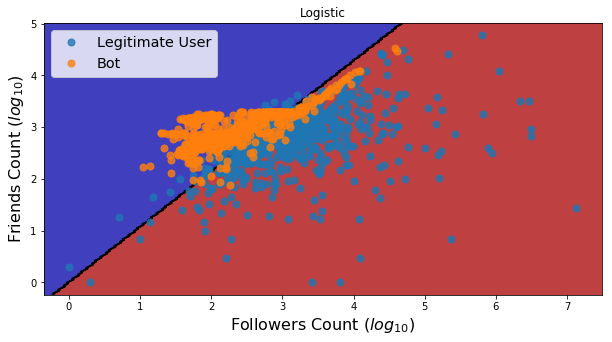

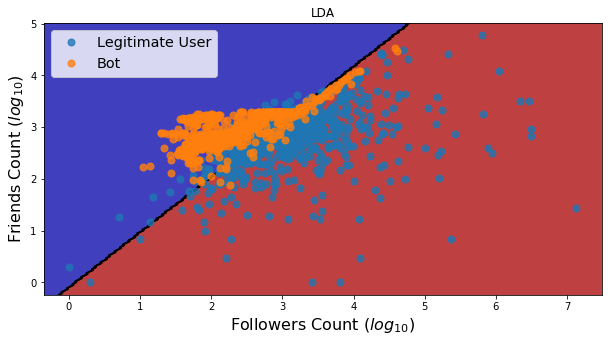

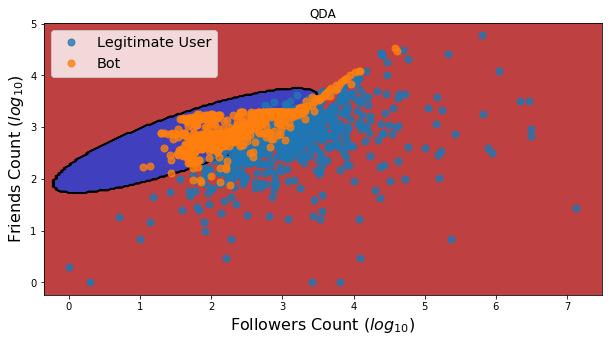

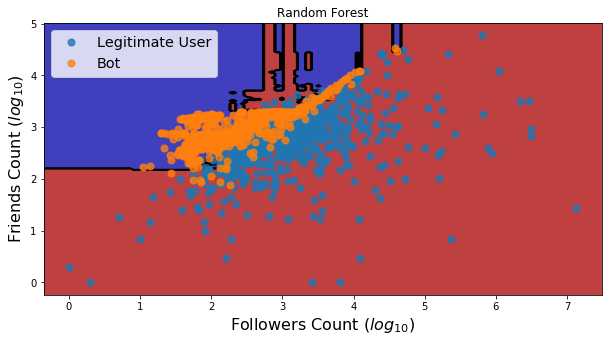

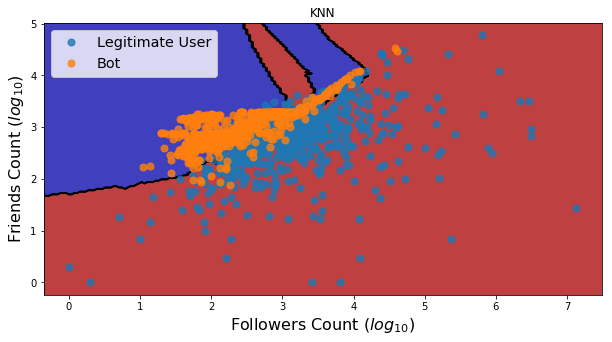

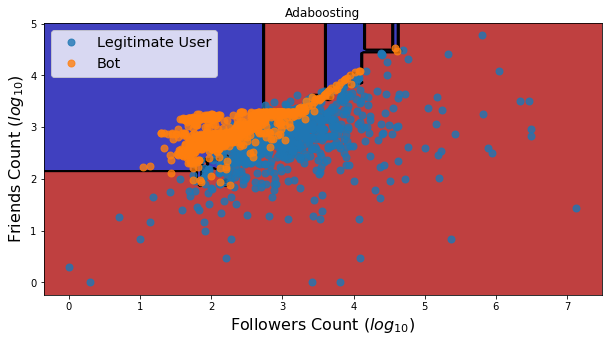

In [59]:
fitted_models = [logreg, lda, qda,rf, knn_best_k, adaboost]
titles = ['Logistic','LDA','QDA','Random Forest','KNN','Adaboosting']

for i, (model, title) in enumerate(zip(fitted_models, titles)):
    f,ax = makeAx_log(df_x=total_df)
    overlay_decision_boundary(ax, model,colors=['red','blue'])
    ax.set_title(title)

plt.show()

# Baseline Model  with more features



In [95]:
bot_df = pd.read_csv(r"bots_dataframe.csv",index_col='User ID')
user_df = pd.read_csv(r"user_dataframe.csv",index_col='User ID')

In [96]:
bot_df['bot']=1
user_df['bot']=0

In [97]:
total_df = bot_df.append(user_df)

In [98]:
train_data, test_data = train_test_split(total_df, test_size = 0.3)

In [99]:
Y_train=train_data['bot']
Y_test=test_data['bot']
X_train=train_data.drop('bot',axis=1)
X_test=test_data.drop('bot',axis=1)


In [100]:
def normalize(df,df_train):
    result = df.copy()
    for feature_name in df_train.columns:
        max_value = df_train[feature_name].max()
        min_value = df_train[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result


In [101]:
X_train_scaled=normalize(X_train,X_train)
X_test_scaled=normalize(X_test,X_train)

## Logistic Regression

In [72]:
logreg = LogisticRegression(C=100000,fit_intercept=True).fit(X_train_scaled,Y_train)
acc = accuracy_score(Y_train,logreg.predict(X_train_scaled), normalize=True)
print('Accuracy of logistic regression model on training set is {:.3f}'.format(acc))
# Classification error on test set
acc_test = accuracy_score(logreg.predict(X_test_scaled), Y_test, normalize=True)
print('Accuracy of logistic regression model on the test set is {:.3f}'.format(acc_test))

Accuracy of logistic regression model on training set is 0.881
Accuracy of logistic regression model on the test set is 0.860


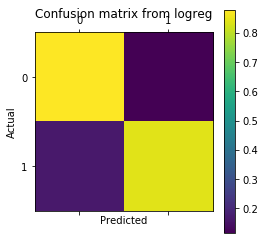

In [73]:
y_pred_logreg= logreg.predict(X_test_scaled)
df_confusion=pd.DataFrame(confusion_matrix(Y_test,y_pred_logreg))

df_conf_norm = df_confusion / df_confusion.sum(axis=1)
df_confusion.index.name='Actual'
df_confusion.columns.name='Predicted'

def plot_confusion_matrix(df_confusion, title='Confusion matrix from logreg', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion) # imshow
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(df_conf_norm)

In [74]:
# Logistic regression w/ quadratic + interaction terms + regularization
polynomial_logreg_estimator = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=True),
    LogisticRegressionCV(multi_class="ovr", penalty='l2', cv=5, max_iter=10000))
linearLogCVpoly = polynomial_logreg_estimator.fit(X_train_scaled, Y_train)
# Compare results
print('Polynomial-logistic accuracy: train={:.1%}, test={:.1%}'.format(
    linearLogCVpoly.score(X_train_scaled, Y_train), linearLogCVpoly.score(X_test_scaled, Y_test)))


Polynomial-logistic accuracy: train=89.2%, test=87.7%


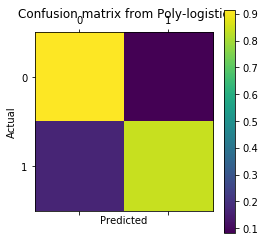

In [75]:

y_pred_PolyL = linearLogCVpoly.predict(X_test_scaled)

df_confusion=pd.DataFrame(confusion_matrix(Y_test,y_pred_PolyL))

df_conf_norm = df_confusion / df_confusion.sum(axis=1)
df_confusion.index.name='Actual'
df_confusion.columns.name='Predicted'

def plot_confusion_matrix(df_confusion, title='Confusion matrix from Poly-logistic', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion) # imshow
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(df_conf_norm)

The logistic regression model does a pretty good job of separating bots from legimitate users with just two features. Once more features are used, the model should be able to predict bots with an even higher accuracy.

## LDA and QDA Model

In this section we run LDA and QDA models to classify the users into either bots or legitimate users.

In [76]:
lda = LinearDiscriminantAnalysis(store_covariance=True)
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
lda.fit(X_train_scaled, Y_train)
qda.fit(X_train_scaled, Y_train)
lda.predict(X_test_scaled)
qda.predict(X_test_scaled)

print('LDA accuracy train={:.1%}, test: {:.1%}'.format(
    lda.score(X_train_scaled, Y_train), lda.score(X_test_scaled, Y_test)))

print('QDA accuracy train={:.1%}, test: {:.1%}'.format(
    qda.score(X_train_scaled, Y_train), qda.score(X_test_scaled, Y_test)))

LDA accuracy train=85.1%, test: 84.0%
QDA accuracy train=83.5%, test: 81.4%


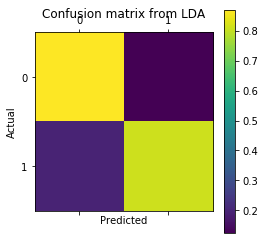

In [77]:

y_pred_lda = lda.predict(X_test_scaled)

df_confusion=pd.DataFrame(confusion_matrix(Y_test,y_pred_lda))

df_conf_norm = df_confusion / df_confusion.sum(axis=1)
df_confusion.index.name='Actual'
df_confusion.columns.name='Predicted'

def plot_confusion_matrix(df_confusion, title='Confusion matrix from LDA', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion) # imshow
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(df_conf_norm)

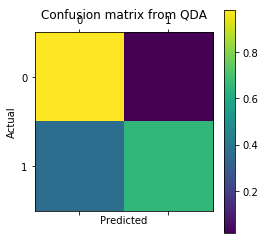

In [78]:
y_pred_qda = qda.predict(X_test_scaled)

df_confusion=pd.DataFrame(confusion_matrix(Y_test,y_pred_qda))

df_conf_norm = df_confusion / df_confusion.sum(axis=1)
df_confusion.index.name='Actual'
df_confusion.columns.name='Predicted'

def plot_confusion_matrix(df_confusion, title='Confusion matrix from QDA', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion) # imshow
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(df_conf_norm)

We see here that the LDA and QDA models perform relatively well at separating this data. However, it did not perform as well as the logistic regression method.

## Random forest

In [79]:
ntrees = 50
rf = RandomForestClassifier(n_estimators=ntrees , max_depth=15, max_features='auto')
rf.fit(X_train_scaled, Y_train)
train_score_rf=rf.score(X_train_scaled, Y_train)
test_score_rf=rf.score(X_test_scaled, Y_test)

print('RF accuracy train={:.1%}, test: {:.1%}'.format(train_score_rf,test_score_rf))
y_pred = rf.predict(X_test_scaled)

df_confusion=pd.DataFrame(confusion_matrix(Y_test,y_pred  ))

df_conf_norm = df_confusion / df_confusion.sum(axis=1)
df_confusion.index.name='Actual'
df_confusion.columns.name='Predicted'

RF accuracy train=100.0%, test: 91.7%


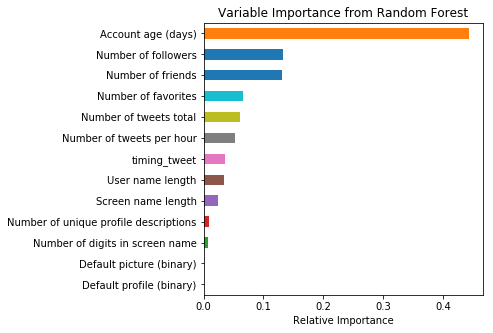

In [80]:
plt.figure(figsize=(5,5))
plt.title('Variable Importance from Random Forest')
plt.xlabel('Relative Importance')
pd.Series(rf.feature_importances_,index=list(X_train_scaled)).sort_values().plot(kind="barh")

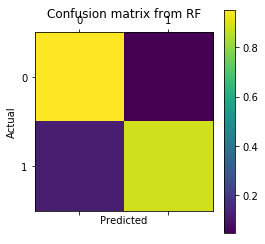

In [81]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix from RF', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion) # imshow
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(df_conf_norm)

## Adaboost

In [82]:
adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=800, learning_rate=0.01)
adaboost.fit(X_train_scaled, Y_train);

Adaboost Test Accuracy: 88.38%


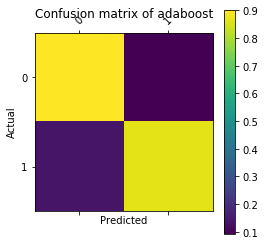

In [83]:
y_pred = adaboost.predict(X_test_scaled)
pred_adaboost = [round(value) for value in y_pred]
accuracy = accuracy_score(Y_test, pred_adaboost)
print("Adaboost Test Accuracy: %.2f%%" % (accuracy * 100.0))
df_confusion=pd.DataFrame(confusion_matrix(Y_test,y_pred  ))

df_conf_norm = df_confusion / df_confusion.sum(axis=1)
df_confusion.index.name='Actual'
df_confusion.columns.name='Predicted'

def plot_confusion_matrix(df_confusion, title='Confusion matrix of adaboost', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion) # imshow
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(df_conf_norm)


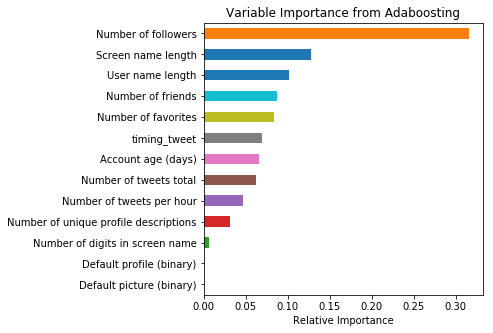

In [84]:
plt.figure(figsize=(5,5))
plt.title('Variable Importance from Adaboosting')
plt.xlabel('Relative Importance')
pd.Series(adaboost.feature_importances_,index=list(X_train_scaled)).sort_values().plot(kind="barh")

In [105]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix

xgb = xgb.XGBClassifier(max_depth=5, n_estimators=300, learning_rate=0.01).fit(X_train_scaled, Y_train)
y_pred = xgb.predict(X_test_scaled)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
df_confusion=pd.DataFrame(confusion_matrix(Y_test,predictions))

df_conf_norm = df_confusion / df_confusion.sum(axis=1)
df_confusion.index.name='Actual'
df_confusion.columns.name='Predicted'

def plot_confusion_matrix(df_confusion, title='Confusion matrix of xgboost', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion) # imshow
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(df_conf_norm)

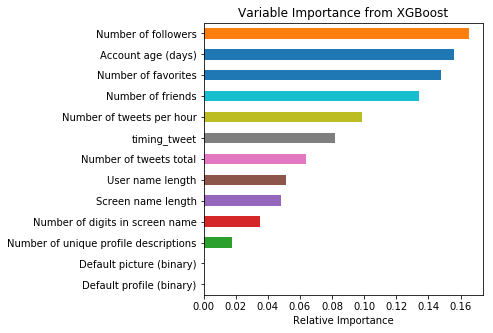

In [107]:
plt.figure(figsize=(5,5))
plt.title('Variable Importance from XGBoost')
plt.xlabel('Relative Importance')
pd.Series(xgb.feature_importances_,index=list(X_train_scaled)).sort_values().plot(kind="barh")

In [89]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

scores_mean=[]
scores_std=[]

k_number=np.arange(1,50)

for k in range(1,50):
    knn = KNeighborsClassifier(n_neighbors = k)
    score_mean= cross_val_score(knn,X_train_scaled,Y_train,cv=5).mean()
    score_std=cross_val_score(knn,X_train_scaled,Y_train,cv=5).std()
    scores_mean.append(score_mean)

In [90]:
max_score_k=max(scores_mean)
best_k=scores_mean.index(max(scores_mean))+1
print('Best K=',best_k, 'with a max CV score of',max_score_k)

knn_best_k = KNeighborsClassifier(n_neighbors = best_k)
knn_best_k.fit(X_train_scaled,Y_train);

pred_best_k = knn_best_k.predict(X_test_scaled)

print('test accuracy',accuracy_score(Y_test, pred_best_k))

Best K= 42 with a max CV score of 0.7960359642129506
test accuracy 0.7807017543859649


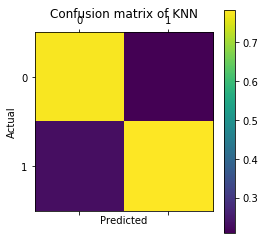

In [91]:
df_confusion=pd.DataFrame(confusion_matrix(Y_test,pred_best_k ))

df_conf_norm = df_confusion / df_confusion.sum(axis=1)
df_confusion.index.name='Actual'
df_confusion.columns.name='Predicted'

def plot_confusion_matrix(df_confusion, title='Confusion matrix of KNN', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion) # imshow
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(df_conf_norm)

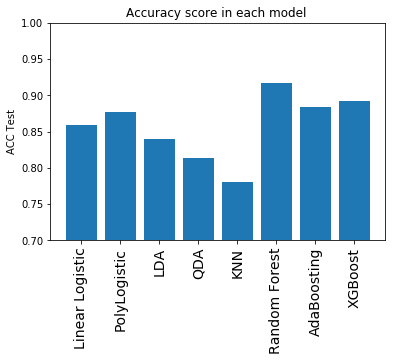

In [92]:
acc_scores=[accuracy_score(logreg.predict(X_test_scaled), Y_test),linearLogCVpoly.score(X_test_scaled, Y_test),lda.score(X_test_scaled, Y_test),qda.score(X_test_scaled, Y_test),accuracy_score(Y_test, pred_best_k),rf.score(X_test_scaled, Y_test),accuracy_score(Y_test, pred_adaboost),accuracy_score(Y_test, predictions)]

xx = [1,2,3,4,5,6,7,8]
index_name=['Linear Logistic','PolyLogistic', 'LDA','QDA','KNN','Random Forest','AdaBoosting','XGBoost']
plt.bar(xx, acc_scores)
plt.ylim(0.7,1)
plt.title('Accuracy score in each model ')
plt.ylabel('ACC Test')
plt.xticks(xx,index_name,rotation=90,fontsize = 14);

## Support Vector Machines

In this section we will use a support vector machine technique to separate the data.

In [0]:
def plot_decision_boundary(x, y, model, title, ax, bounds=(0, 6), poly_flag=False):
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], c='green')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], c='gray', alpha=0.3)
    
    # Create mesh
    interval = np.arange(bounds[0], bounds[1], 0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_flag):
        quad_features = preprocessing.PolynomialFeatures(degree=2)
        xx = quad_features.fit_transform(xx)
        
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # Plot decision surface
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    
    # Label axes, set title
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

In [0]:
def fit_and_plot_svm_for_c(x_train, y_train, x_test, y_test, C):
    # Fit SVM model
    model = svm.SVC(C=C, kernel='linear')
    model.fit(x_train, y_train)
    
    # Train and test error
    tr_acc = model.score(x_train, y_train)
    ts_acc = model.score(x_test, y_test)

    # Plot decision boundary
    #plot_decision_boundary(x_train, y_train, model, \
    #                       'C = ' + str(C)\
    #                       + ', train acc = ' + str(tr_acc)\
    #                       + ', test acc = ' + str(ts_acc), ax, bounds)
    
    # Plot support vectors
    #sv_indices = model.support_ # retrieve the support vector indices
    #ax.scatter(x_train[sv_indices, 0], x_train[sv_indices, 1], color='red', alpha=0.15, s=100) # draw circles around SVs
    
    return tr_acc, ts_acc

In [0]:
# Fit and plot for different 'C' values
tr1, ts1 = fit_and_plot_svm_for_c(X_train, Y_train, X_test, Y_test, 0.1)
print(tr1,ts1)

tr2, ts2 = fit_and_plot_svm_for_c(X_train, Y_train, X_test, Y_test, 0.5)
print(tr2,ts2)

tr3, ts3 = fit_and_plot_svm_for_c(X_train, Y_train, X_test, Y_test, 1)
print(tr3,ts3)

tr4, ts4 = fit_and_plot_svm_for_c(X_train, Y_train, X_test, Y_test, 10)
print(tr4,ts4)

tr5, ts5 = fit_and_plot_svm_for_c(X_train, Y_train, X_test, Y_test, 100)
print(tr5,ts5)

tr6, ts6 = fit_and_plot_svm_for_c(X_train, Y_train, X_test, Y_test, 1000)
print(tr6,ts6)

#plt.tight_layout()

0.8679593721144968 0.896774193548387
0.8679593721144968 0.896774193548387
0.8670360110803325 0.9075268817204301
0.863342566943675 0.9053763440860215
0.8642659279778393 0.9053763440860215
0.8688827331486612 0.9032258064516129


In [0]:
def fit_and_plot_svm_for_poly_c(X_train_log, Y_train, X_test_log, Y_test, C, degree = 2):
    # Fit SVM model
    model = svm.SVC(C=C, kernel='poly', degree=degree)
    model.fit(X_train, Y_train)
    
    # Train and test error
    tr_acc = model.score(X_train, Y_train)
    ts_acc = model.score(X_test, Y_test)

    # Plot decision boundary
    #plot_decision_boundary(X_train, Y_train, model, \
    #                       'C = ' + str(C)\
    ##                       + ', train acc = ' + str(tr_acc)\
     #                      + ', test acc = ' + str(ts_acc), ax, bounds)
    
    # Plot support vectors
    #sv_indices = model.support_ # retrieve the support vector indices
    #ax.scatter(X_train_log[sv_indices, 0], X_train[sv_indices, 1], color='red', alpha=0.15, s=100) # draw circles around SVs
    
    return tr_acc, ts_acc

In [0]:
# Fit and plot for different 'C' values when polynomial degree is 2
#fig, ax = plt.subplots(2, 3, figsize = (15, 10))

deg = 4

tr7, ts7 = fit_and_plot_svm_for_poly_c(X_train, Y_train, X_test, Y_test, 0.5, degree = deg)
print(tr7,ts7)

tr8, ts8 = fit_and_plot_svm_for_poly_c(X_train, Y_train, X_test, Y_test, 1, degree = deg)
print(tr8,ts8)

tr9, ts9 = fit_and_plot_svm_for_poly_c(X_train, Y_train, X_test, Y_test, 10, degree = deg)
print(tr9,ts9)

tr10, ts10  = fit_and_plot_svm_for_poly_c(X_train, Y_train, X_test, Y_test, 100, degree = deg)
print(tr10,ts10)

tr11, ts11 = fit_and_plot_svm_for_poly_c(X_train, Y_train, X_test, Y_test, 1000, degree = deg)
print(tr11,ts11)

tr12, ts12 = fit_and_plot_svm_for_poly_c(X_train, Y_train, X_test, Y_test, 10000, degree = deg)
print(tr12,ts12)

#plt.tight_layout()

0.7109879963065558 0.7376344086021506
0.7109879963065558 0.7376344086021506
0.7109879963065558 0.7376344086021506
0.7109879963065558 0.7376344086021506
0.7109879963065558 0.7376344086021506
0.7109879963065558 0.7376344086021506


In [0]:
# Fit and plot for different degrees for polynomial boundary...this takes a while
#fig, ax = plt.subplots(2, 2, figsize = (15, 10))

tr13,ts13 = fit_and_plot_svm_for_poly_c(X_train, Y_train, X_test, Y_test, 1000, degree = 1)
print(tr13,ts13)

tr14, ts14 = fit_and_plot_svm_for_poly_c(X_train, Y_train, X_test, Y_test, 1000, degree = 2)
print(tr14,ts14)

tr15, ts15 = fit_and_plot_svm_for_poly_c(X_train, Y_train, X_test, Y_test, 1000, degree = 3)
print(tr15,ts15)

tr16,ts16 = fit_and_plot_svm_for_poly_c(X_train, Y_train, X_test, Y_test, 1000, degree = 4)
print(tr16,ts16)

#plt.tight_layout()

0.8688827331486612 0.9032258064516129


In [0]:
# What about other kernels?
def fit_and_plot_svm_for_kernels(x_train, y_train, x_test, y_test, C, kernel = 'rbf'):
    # Fit SVM model
    model = svm.SVC(C=C, kernel=kernel)
    model.fit(X_train, Y_train)
    
    # Train and test error
    tr_acc = model.score(X_train, Y_train)
    ts_acc = model.score(X_test, Y_test)

    # Plot decision boundary
    #plot_decision_boundary(x_train, y_train, model, \
    #                       'C = ' + str(C)\
    #                       + ', train acc = ' + str(tr_acc)\
    #                       + ', test acc = ' + str(ts_acc), ax, bounds)
   # 
    # Plot support vectors
    #sv_indices = model.support_ # retrieve the support vector indices
    #ax.scatter(x_train[sv_indices, 0], x_train[sv_indices, 1], color='red', alpha=0.15, s=100) # draw circles around SVs
    
    return tr_acc, ts_acc

In [0]:
#fig, ax = plt.subplots(2, 3, figsize = (15, 10))

tr17, ts17 = fit_and_plot_svm_for_kernels(X_train, Y_train, X_test, Y_test, 100, kernel = "poly")
print(tr17,ts17)

tr18, ts18 = fit_and_plot_svm_for_kernels(X_train, Y_train, X_test, Y_test, 100, kernel = "rbf")
print(tr18,ts18)

tr19, ts19 = fit_and_plot_svm_for_kernels(X_train, Y_train, X_test, Y_test, 100, kernel = "sigmoid")
print(tr19,ts19)

tr20, ts20 = fit_and_plot_svm_for_kernels(X_train, Y_train, X_test, Y_test, 1000, kernel = "poly")
print(tr20,ts20)

tr21, ts21 = fit_and_plot_svm_for_kernels(X_train, Y_train, X_test, Y_test, 1000, kernel = "rbf")
print(tr21,ts21)

tr22, ts22 = fit_and_plot_svm_for_kernels(X_train, Y_train, X_test, Y_test, 1000, kernel = "sigmoid")
print(tr22, ts22)

#plt.tight_layout()